<a href="https://colab.research.google.com/github/lauramoraes/Analise_de_Clusters/blob/master/1%20-%20Modelagem/4%20-%20Conectando%20matriz%20de%20covari%C3%A2ncia%20e%20redu%C3%A7%C3%A3o%20de%20dimensionalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redução de dimensionalidade

### Importando bibliotecas a serem usadas

In [8]:
library(tidyverse)
library(reshape2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



## O que a matriz de covariância e a dimensão do dados tem a ver?

Mas você deve estar se perguntando, o que a matriz de covariância e a dimensão mencionadas anteriormente tem em comum?

Como havíamos dito, a **dimensão do dado** é o número de atributos **independentes** que um dataset contém e que, sendo esse número acima de 3 (ou 4, 5 se adicionarmos informações como forma e cor) fica impossível de visualizarmos.

Pois bem, com a matriz de covariância conseguimos descobrir quais atributos possuem relações lineares uns com outros e a magnitude dessa relação. A partir daí, é possível criar novos atributos que sejam **combinações** dos atributos originais, mas **independentes** entre si. 

#### E como isso ajuda na visualização?
Imagine a sua sombra. Ela é a projeção em 2D do nosso objeto 3D (você, no caso). Ao diminuirmos uma dimensão, estamos comprimindo informação. Nesse caso, estamos colocando pontos de diferentes coordenadas (x,y,z) em um mesmo lugar na sombra. Agora, quando conseguimos observar mais detalhes do seu corpo? No sol de meio-dia ou de seis da tarde? A sombra fica maior (portanto, com menos pontos colidindo) quando o sombra está na direção de maior variância do seu corpo. Essa direção não é nem a altura nem a largura, mas uma combinação dos dois.

Os **autovetores** e **autovalores** de uma matriz são calculados de uma maneira que apontam para a **direção de maior variância** dos dados. Ou seja, quando descobrirmos essas direções, podemos criar uma "sombra" dos dados em dimensão menor e evitar o máximo de colisões possíveis para aquela visualização.

#### Redução de dimensionalidade
PCA, SVD, ... são alguns nomes que essa técnica possui, diferindo na matriz de entrada. Vamos continuar o exemplo ilustrativo do notebook anterior para entendermos como descobrimos as direções de maior variância a partir da matriz de covariância.

### Matriz de escalonamento
Vamos começar transformando os nossos dados com a matriz de escalonamento S, onde a transformação somente escala as componentes x e y multiplicando elas por $s_x$ e $s_y$, respectivamente.

$ S = \begin{bmatrix}
s_x & 0\\ 
0 & s_y
\end{bmatrix}$

Nesse caso, a matriz de covariância C será:

$ C = \begin{bmatrix}
(s_x\sigma_x)^2 & 0\\ 
0 & (s_y\sigma_y)^2
\end{bmatrix}$

O que significa que conseguimos extrair a matriz de escalonamento S a partir de C, onde $S = \sqrt{C}$

Sx =  0.7096694 
Sx original =  0.7 
Sy =  3.338004 
Sy original =  3.4

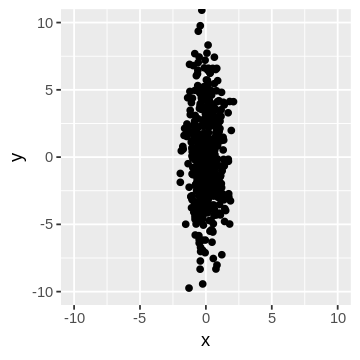

In [63]:
options(repr.plot.width=3, repr.plot.height=3)
# Primeiro, vamos gerar pontos aleatórios com média zero e variância 1 em cada direção (sem correlação entre elas)
# Constantes
N = 500
noise = 0.25

# Gerando dados sintéticos
x = rnorm(N)
y = rnorm(N)

# Criando o dataframe e convertendo para matriz
df  <- data.frame(x = x, y = y)
M <- data.matrix(df)

# Criando a matriz de escalonamento
sx <- 0.7
sy <- 3.4
S <- rbind(c(sx,0), c(0,sy))

# Transformando a matriz original
SM <- M %*% S
colnames(SM) <- c("x","y")
SM_df  <- data.frame(x = SM[,"x"], y = SM[,"y"])

# Plotando os dados
ggplot(data = SM_df, aes(x,y)) + 
  geom_point() +
  coord_cartesian(xlim = c(-10, 10), ylim = c(-10, 10))

# Extraindo de volta a matriz S
C <- cov(SM)
cat("Sx = ", sqrt(subset(melt(C), Var1=="x" & Var2=="x")$value), '\n')
cat("Sx original = ", sx, '\n')
cat("Sy = ", sqrt(subset(melt(C), Var1=="y" & Var2=="y")$value), '\n')
cat("Sy original = ", sy)

Agora vamos aplicar uma matriz de transformação T, que consiste em uma matriz de rotação R e a matriz de escalonamento S.

$ T = RS $

onde R é dado por:

$ C = \begin{bmatrix}
cos(\theta) & -sen(\theta)\\ 
sen(\theta) & cos(\theta)
\end{bmatrix}$

Mas, partindo da matriz de covariância C, como recuperar R e S?

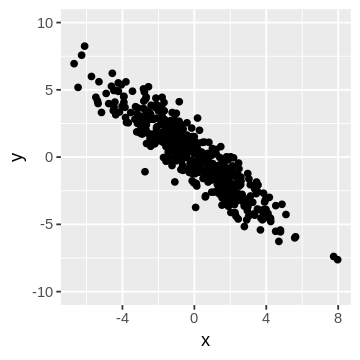

In [77]:
options(repr.plot.width=3, repr.plot.height=3)
# Primeiro, vamos gerar pontos aleatórios com média zero e variância 1 em cada direção (sem correlação entre elas)
# Constantes
N = 500
noise = 0.25

# Gerando dados sintéticos
x = rnorm(N)
y = rnorm(N)

# Criando o dataframe e convertendo para matriz
df  <- data.frame(x = x, y = y)
M <- data.matrix(df)

# Criando a matriz de escalonamento
sx <- 0.7
sy <- 3.4
S <- rbind(c(sx,0), c(0,sy))

# Criando a matriz de rotação
theta <- 0.77*pi
R <- rbind(c(cos(theta),-sin(theta)), c(sin(theta),cos(theta)))

# Transformando a matriz original
T <- S %*% R
TM <- M %*% T
colnames(TM) <- c("x","y")
TM_df  <- data.frame(x = TM[,"x"], y = TM[,"y"])

# Plotando os dados
ggplot(data = TM_df, aes(x,y)) + 
  geom_point() +
  coord_cartesian(ylim = c(-10, 10))